# Training BERT for NLU given limited amount of data

## Imports and configuration

In [1]:
import os
import sys

sys.path.append("../bert")

import run_bert_nlu_pytorch
from run_bert_nlu_pytorch import main as run_bert

In [2]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import numpy as np
from matplotlib import pyplot as plt
import torch

In [3]:
def outdir(tag):
    return os.path.expanduser("~/output/{}_ARGSHASH".format(tag))

In [4]:
defaults = {'train_batch_size': 32,
            'learning_rate': 2e-5,
            'save_checkpoints_steps': 5000,
            'eval_steps': 250,
            'dev_set': 0.25,
            'layers': 6,
            'fp16': True,
            'do_train': True,
            'eval_with_known_intents': True,
            'seed': 1}

In [5]:
intents = ['AddToPlaylist', 'BookRestaurant', 'GetWeather', 'PlayMusic',
           'RateBook', 'SearchCreativeWork', 'SearchScreeningEvent']

# Pre-fine-tuning BERT on 6 intents
Here we eliminate one of the intents from the training set and fine-tune on the rest of the intents. Note that we are training on the joint task of slot filling and intent classification, however we evaluate only on slot filling (that's because I was lazy to disable training on intent classification, but I think it shouldn't influence the results much).

In [6]:
# Run 8 epochs on 6 intents
paths_on6 = {}
for excluded_intent in intents:
    paths_on6[excluded_intent] = \
        run_bert(**defaults,
                 output_dir=outdir("BERT_NLU_6INT"),
                 bert_model='bert-base-uncased',
                 num_train_epochs=8,
                 limit_data={excluded_intent: 0})

07/29/2019 11:25:38 - INFO - run_bert_nlu_pytorch -   device: cuda n_gpu: 1, distributed training: False, 16-bits training: True
07/29/2019 11:25:38 - INFO - run_bert_nlu_pytorch -   Output dir /workspace/output/BERT_NLU_6INT_0c760f3c already exists, doing nothing
07/29/2019 11:25:38 - INFO - run_bert_nlu_pytorch -   device: cuda n_gpu: 1, distributed training: False, 16-bits training: True
07/29/2019 11:25:38 - INFO - run_bert_nlu_pytorch -   Output dir /workspace/output/BERT_NLU_6INT_69b509e0 already exists, doing nothing
07/29/2019 11:25:38 - INFO - run_bert_nlu_pytorch -   device: cuda n_gpu: 1, distributed training: False, 16-bits training: True
07/29/2019 11:25:38 - INFO - run_bert_nlu_pytorch -   Output dir /workspace/output/BERT_NLU_6INT_fc1c2449 already exists, doing nothing
07/29/2019 11:25:38 - INFO - run_bert_nlu_pytorch -   device: cuda n_gpu: 1, distributed training: False, 16-bits training: True
07/29/2019 11:25:38 - INFO - run_bert_nlu_pytorch -   Output dir /workspace/

Now we are fine-tuning on 10 sentences from the eliminated intent. Note that we use different 10-sentence subsets (this is controlled by `shift`), we also try to freeze some layers in some runs.

In [7]:
paths_on10samples = {}
for excluded_intent in intents:
    only_this_intent = {intent: 0 for intent in intents}
    only_this_intent[excluded_intent] = (10, 150)
    
    res = {}
    
    for shift in range(32, 72, 10):
        res.setdefault("6int_then_1int", []).append(
            run_bert(**defaults,
                     output_dir=outdir("BERT_NLU_6INT_THEN_1INT"),
                     bert_model=paths_on6[excluded_intent] + "/checkpoint_final",
                     num_train_epochs=16,
                     shift_limited_data=shift,
                     limit_data=only_this_intent))
        res.setdefault("just_1int", []).append(
            run_bert(**defaults,
                     output_dir=outdir("BERT_NLU_1INT"),
                     bert_model='bert-base-uncased',
                     num_train_epochs=16,
                     shift_limited_data=shift,
                     limit_data=only_this_intent))
        for layers_from in [100, 5, 4, 3]:
            res.setdefault("6int_then_1int_layers_from_" + str(layers_from), []).append(
                run_bert(**defaults,
                         output_dir=outdir("BERT_NLU_6INT_THEN_1INT"),
                         bert_model=paths_on6[excluded_intent] + "/checkpoint_final",
                         num_train_epochs=16,
                         limit_data=only_this_intent,
                         shift_limited_data=shift,
                         train_layers_from=layers_from))
            
    
    paths_on10samples[excluded_intent] = res

07/29/2019 11:25:38 - INFO - run_bert_nlu_pytorch -   device: cuda n_gpu: 1, distributed training: False, 16-bits training: True
07/29/2019 11:25:38 - INFO - run_bert_nlu_pytorch -   Output dir /workspace/output/BERT_NLU_6INT_THEN_1INT_e8010148 already exists, doing nothing
07/29/2019 11:25:38 - INFO - run_bert_nlu_pytorch -   device: cuda n_gpu: 1, distributed training: False, 16-bits training: True
07/29/2019 11:25:38 - INFO - run_bert_nlu_pytorch -   Output dir /workspace/output/BERT_NLU_1INT_5022f852 already exists, doing nothing
07/29/2019 11:25:38 - INFO - run_bert_nlu_pytorch -   device: cuda n_gpu: 1, distributed training: False, 16-bits training: True
07/29/2019 11:25:38 - INFO - run_bert_nlu_pytorch -   Output dir /workspace/output/BERT_NLU_6INT_THEN_1INT_6a6629f2 already exists, doing nothing
07/29/2019 11:25:38 - INFO - run_bert_nlu_pytorch -   device: cuda n_gpu: 1, distributed training: False, 16-bits training: True
07/29/2019 11:25:38 - INFO - run_bert_nlu_pytorch -   Ou

07/29/2019 11:25:39 - INFO - run_bert_nlu_pytorch -   device: cuda n_gpu: 1, distributed training: False, 16-bits training: True
07/29/2019 11:25:39 - INFO - run_bert_nlu_pytorch -   Output dir /workspace/output/BERT_NLU_6INT_THEN_1INT_90a64da0 already exists, doing nothing
07/29/2019 11:25:39 - INFO - run_bert_nlu_pytorch -   device: cuda n_gpu: 1, distributed training: False, 16-bits training: True
07/29/2019 11:25:39 - INFO - run_bert_nlu_pytorch -   Output dir /workspace/output/BERT_NLU_1INT_f5be2cbf already exists, doing nothing
07/29/2019 11:25:39 - INFO - run_bert_nlu_pytorch -   device: cuda n_gpu: 1, distributed training: False, 16-bits training: True
07/29/2019 11:25:39 - INFO - run_bert_nlu_pytorch -   Output dir /workspace/output/BERT_NLU_6INT_THEN_1INT_e05d1bd7 already exists, doing nothing
07/29/2019 11:25:39 - INFO - run_bert_nlu_pytorch -   device: cuda n_gpu: 1, distributed training: False, 16-bits training: True
07/29/2019 11:25:39 - INFO - run_bert_nlu_pytorch -   Ou

07/29/2019 11:25:39 - INFO - run_bert_nlu_pytorch -   device: cuda n_gpu: 1, distributed training: False, 16-bits training: True
07/29/2019 11:25:39 - INFO - run_bert_nlu_pytorch -   Output dir /workspace/output/BERT_NLU_6INT_THEN_1INT_5f92373a already exists, doing nothing
07/29/2019 11:25:39 - INFO - run_bert_nlu_pytorch -   device: cuda n_gpu: 1, distributed training: False, 16-bits training: True
07/29/2019 11:25:39 - INFO - run_bert_nlu_pytorch -   Output dir /workspace/output/BERT_NLU_1INT_24e1b45c already exists, doing nothing
07/29/2019 11:25:39 - INFO - run_bert_nlu_pytorch -   device: cuda n_gpu: 1, distributed training: False, 16-bits training: True
07/29/2019 11:25:39 - INFO - run_bert_nlu_pytorch -   Output dir /workspace/output/BERT_NLU_6INT_THEN_1INT_0328a9f7 already exists, doing nothing
07/29/2019 11:25:39 - INFO - run_bert_nlu_pytorch -   device: cuda n_gpu: 1, distributed training: False, 16-bits training: True
07/29/2019 11:25:39 - INFO - run_bert_nlu_pytorch -   Ou

07/29/2019 11:25:39 - INFO - run_bert_nlu_pytorch -   device: cuda n_gpu: 1, distributed training: False, 16-bits training: True
07/29/2019 11:25:39 - INFO - run_bert_nlu_pytorch -   Output dir /workspace/output/BERT_NLU_6INT_THEN_1INT_2875be68 already exists, doing nothing
07/29/2019 11:25:39 - INFO - run_bert_nlu_pytorch -   device: cuda n_gpu: 1, distributed training: False, 16-bits training: True
07/29/2019 11:25:39 - INFO - run_bert_nlu_pytorch -   Output dir /workspace/output/BERT_NLU_1INT_a1c9d2e0 already exists, doing nothing
07/29/2019 11:25:39 - INFO - run_bert_nlu_pytorch -   device: cuda n_gpu: 1, distributed training: False, 16-bits training: True
07/29/2019 11:25:39 - INFO - run_bert_nlu_pytorch -   Output dir /workspace/output/BERT_NLU_6INT_THEN_1INT_a0da7179 already exists, doing nothing
07/29/2019 11:25:39 - INFO - run_bert_nlu_pytorch -   device: cuda n_gpu: 1, distributed training: False, 16-bits training: True
07/29/2019 11:25:39 - INFO - run_bert_nlu_pytorch -   Ou

07/29/2019 11:25:39 - INFO - run_bert_nlu_pytorch -   device: cuda n_gpu: 1, distributed training: False, 16-bits training: True
07/29/2019 11:25:39 - INFO - run_bert_nlu_pytorch -   Output dir /workspace/output/BERT_NLU_6INT_THEN_1INT_bb01edf7 already exists, doing nothing
07/29/2019 11:25:39 - INFO - run_bert_nlu_pytorch -   device: cuda n_gpu: 1, distributed training: False, 16-bits training: True
07/29/2019 11:25:39 - INFO - run_bert_nlu_pytorch -   Output dir /workspace/output/BERT_NLU_1INT_c127c49a already exists, doing nothing
07/29/2019 11:25:39 - INFO - run_bert_nlu_pytorch -   device: cuda n_gpu: 1, distributed training: False, 16-bits training: True
07/29/2019 11:25:39 - INFO - run_bert_nlu_pytorch -   Output dir /workspace/output/BERT_NLU_6INT_THEN_1INT_b82d0b83 already exists, doing nothing
07/29/2019 11:25:39 - INFO - run_bert_nlu_pytorch -   device: cuda n_gpu: 1, distributed training: False, 16-bits training: True
07/29/2019 11:25:39 - INFO - run_bert_nlu_pytorch -   Ou

07/29/2019 11:25:39 - INFO - run_bert_nlu_pytorch -   device: cuda n_gpu: 1, distributed training: False, 16-bits training: True
07/29/2019 11:25:39 - INFO - run_bert_nlu_pytorch -   Output dir /workspace/output/BERT_NLU_6INT_THEN_1INT_c11bb722 already exists, doing nothing
07/29/2019 11:25:39 - INFO - run_bert_nlu_pytorch -   device: cuda n_gpu: 1, distributed training: False, 16-bits training: True
07/29/2019 11:25:39 - INFO - run_bert_nlu_pytorch -   Output dir /workspace/output/BERT_NLU_1INT_20ca34db already exists, doing nothing
07/29/2019 11:25:39 - INFO - run_bert_nlu_pytorch -   device: cuda n_gpu: 1, distributed training: False, 16-bits training: True
07/29/2019 11:25:39 - INFO - run_bert_nlu_pytorch -   Output dir /workspace/output/BERT_NLU_6INT_THEN_1INT_c68e4c7d already exists, doing nothing
07/29/2019 11:25:39 - INFO - run_bert_nlu_pytorch -   device: cuda n_gpu: 1, distributed training: False, 16-bits training: True
07/29/2019 11:25:39 - INFO - run_bert_nlu_pytorch -   Ou

In [8]:
import torch
torch.cuda.empty_cache()

In [9]:
paths_on10samples

{'AddToPlaylist': {'6int_then_1int': ['/workspace/output/BERT_NLU_6INT_THEN_1INT_e8010148',
   '/workspace/output/BERT_NLU_6INT_THEN_1INT_c8486feb',
   '/workspace/output/BERT_NLU_6INT_THEN_1INT_5ba28e9f',
   '/workspace/output/BERT_NLU_6INT_THEN_1INT_3062b091'],
  'just_1int': ['/workspace/output/BERT_NLU_1INT_5022f852',
   '/workspace/output/BERT_NLU_1INT_139a6bdc',
   '/workspace/output/BERT_NLU_1INT_074628cc',
   '/workspace/output/BERT_NLU_1INT_e10d811e'],
  '6int_then_1int_layers_from_100': ['/workspace/output/BERT_NLU_6INT_THEN_1INT_6a6629f2',
   '/workspace/output/BERT_NLU_6INT_THEN_1INT_14a7f792',
   '/workspace/output/BERT_NLU_6INT_THEN_1INT_9810b456',
   '/workspace/output/BERT_NLU_6INT_THEN_1INT_2f31287f'],
  '6int_then_1int_layers_from_5': ['/workspace/output/BERT_NLU_6INT_THEN_1INT_a9434997',
   '/workspace/output/BERT_NLU_6INT_THEN_1INT_a4aa2257',
   '/workspace/output/BERT_NLU_6INT_THEN_1INT_5578d07c',
   '/workspace/output/BERT_NLU_6INT_THEN_1INT_bae7d8cf'],
  '6int_th

## Learning curves of pre-fine-tuning BERT on 6 intents, and then fine-tuning on 10 sentences from the eliminated intent
Well, this is basically a demonstration of catastrophic forgetting, I don't think these curves are useful in any way. Note that we tried to train on different 10-sentence subsets, but here we show only the first run to avoid cluttering the plot. We also evaluate performance on the intents separately (so all the curves on a single plot show evaluation performance of the same network, but on different intents). As you can guess from the plots we start fine-tuning on 10 sentences somewhere around 2200-th step.

Also I use whole frame accuracy (f1-score will look pretty much the same).

AddToPlaylist


I0729 11:25:40.840364 140613220276032 directory_watcher.py:118] No path found after /workspace/output/BERT_NLU_6INT_0c760f3c/events.out.tfevents.1564042120.788e9ceeb71a
I0729 11:25:40.862091 140613220276032 directory_watcher.py:118] No path found after /workspace/output/BERT_NLU_6INT_THEN_1INT_e8010148/events.out.tfevents.1564045387.788e9ceeb71a


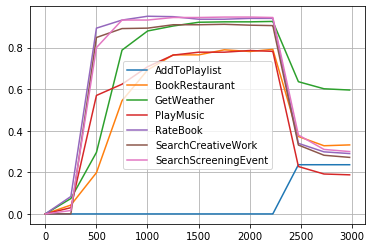

I0729 11:25:41.133741 140613220276032 directory_watcher.py:118] No path found after /workspace/output/BERT_NLU_6INT_69b509e0/events.out.tfevents.1564042568.788e9ceeb71a
I0729 11:25:41.150413 140613220276032 directory_watcher.py:118] No path found after /workspace/output/BERT_NLU_6INT_THEN_1INT_ee9b69c6/events.out.tfevents.1564048406.788e9ceeb71a


BookRestaurant


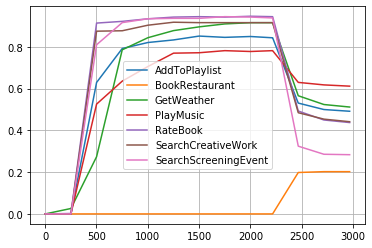

I0729 11:25:41.417150 140613220276032 directory_watcher.py:118] No path found after /workspace/output/BERT_NLU_6INT_fc1c2449/events.out.tfevents.1564043018.788e9ceeb71a
I0729 11:25:41.433778 140613220276032 directory_watcher.py:118] No path found after /workspace/output/BERT_NLU_6INT_THEN_1INT_558da78d/events.out.tfevents.1564051426.788e9ceeb71a


GetWeather


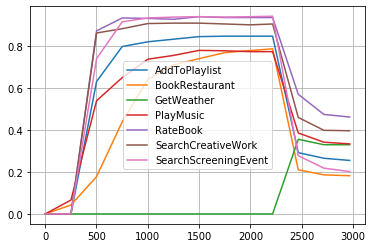

I0729 11:25:41.678956 140613220276032 directory_watcher.py:118] No path found after /workspace/output/BERT_NLU_6INT_4a11b71a/events.out.tfevents.1564043466.788e9ceeb71a
I0729 11:25:41.695720 140613220276032 directory_watcher.py:118] No path found after /workspace/output/BERT_NLU_6INT_THEN_1INT_7757c2c4/events.out.tfevents.1564054444.788e9ceeb71a


PlayMusic


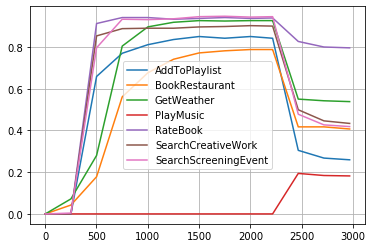

I0729 11:25:41.932073 140613220276032 directory_watcher.py:118] No path found after /workspace/output/BERT_NLU_6INT_b03c823f/events.out.tfevents.1564043917.788e9ceeb71a
I0729 11:25:41.949052 140613220276032 directory_watcher.py:118] No path found after /workspace/output/BERT_NLU_6INT_THEN_1INT_faae02e5/events.out.tfevents.1564057459.788e9ceeb71a


RateBook


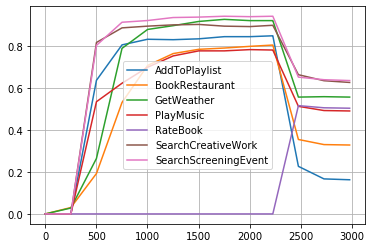

I0729 11:25:42.178068 140613220276032 directory_watcher.py:118] No path found after /workspace/output/BERT_NLU_6INT_5ca9c27c/events.out.tfevents.1564044489.788e9ceeb71a
I0729 11:25:42.195147 140613220276032 directory_watcher.py:118] No path found after /workspace/output/BERT_NLU_6INT_THEN_1INT_bb01edf7/events.out.tfevents.1564060481.788e9ceeb71a


SearchCreativeWork


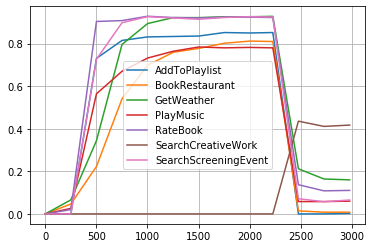

I0729 11:25:42.411610 140613220276032 directory_watcher.py:118] No path found after /workspace/output/BERT_NLU_6INT_a29071ef/events.out.tfevents.1564044941.788e9ceeb71a
I0729 11:25:42.428696 140613220276032 directory_watcher.py:118] No path found after /workspace/output/BERT_NLU_6INT_THEN_1INT_bdfab918/events.out.tfevents.1564063502.788e9ceeb71a


SearchScreeningEvent


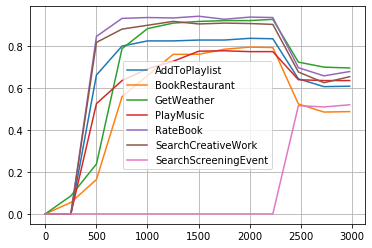

In [10]:
def load_scalars(path):
    metric = "eval_whole_frame_accuracy_intentless_"
    #metric = "eval_f1_score_seqeval_"
    
    event_acc = EventAccumulator(path)
    event_acc.Reload()
    #print(event_acc.Tags())
    all_steps = None
    intent_values = {}
    for intent in intents:
        wall_times, global_steps, values = \
            zip(*event_acc.Scalars(metric + intent))
        intent_values[intent] = dict(zip(global_steps, values))
        if all_steps is None:
            all_steps = set(global_steps)
        else:
            all_steps = all_steps & set(global_steps)
    return {intent: tuple(zip(*[(s, intent_values[intent][s]) for s in sorted(all_steps)])) 
            for intent in intents}

def combine(lhs, rhs):
    res = {}
    for intent in intents:
        lsteps, lvals = lhs[intent]
        rsteps, rvals = rhs[intent]
        res[intent] = (list(lsteps) + [s + lsteps[-1] for s in rsteps], lvals + rvals)
    return res



colors = {intent: 'C' + str(i) for i, intent in enumerate(intents)}

for cur_intent in intents:
    print(cur_intent)

    for intent, (steps, vals) in combine(load_scalars(paths_on6[cur_intent]), 
                                         load_scalars(paths_on10samples[cur_intent]['6int_then_1int'][0])).items():
        plt.plot(steps, vals, label=intent, color=colors[intent])
    plt.grid()

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())

    plt.show()

In [11]:
%matplotlib inline

## Freezing some of layers during fine-tuning on 10 sentences
Now let's see how the final score of the limited intent depends on the number of layers we train. We have the following training modes:
- `just_1int` fine-tuning BERT on 10 sentences from the given intent
- `6int_then_1int` fine-tuning on 6 intents, then fine-tuning the whole network on 10 sentences from the excluded intent
- `6_int_then_1int_layers_from_N` fine-tuning on 6 intents, then fine-tuning on 10 sentences, but only the layers starting from N (since we use 6-layer BERT by default, N=5 means that we fine-tune only the last layer, N=4 means last 2 layers, N=3 means last 3 layers, N=100 means only the last dense block)

For each mode we show 4 different runs (trained on different 10-sentence subsets).

It is interesting to note that fine-tuning only 2 layers seems better than fine-tuning full 6 layers.

AddToPlaylist


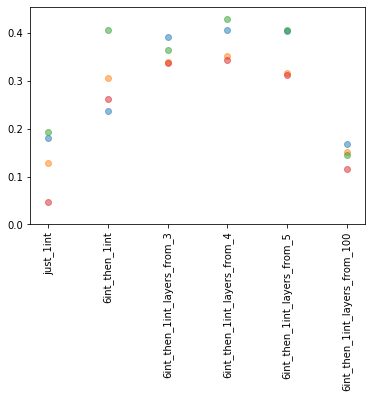

BookRestaurant


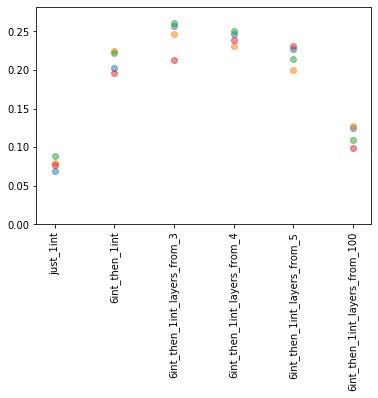

GetWeather


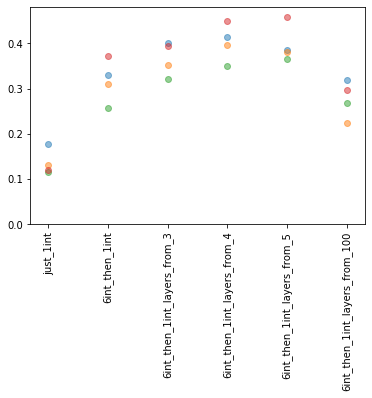

PlayMusic


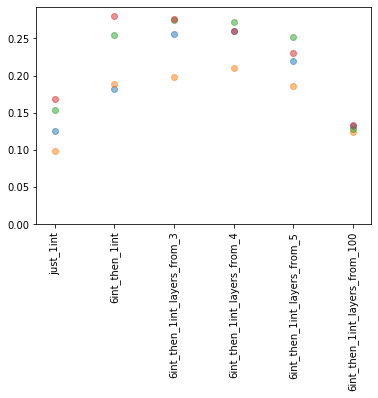

RateBook


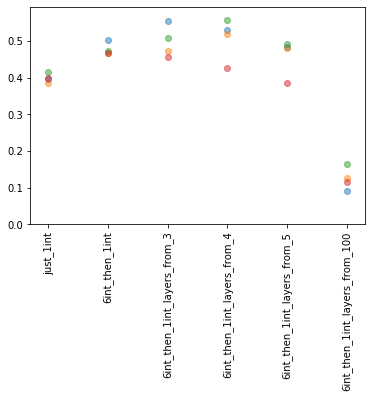

SearchCreativeWork


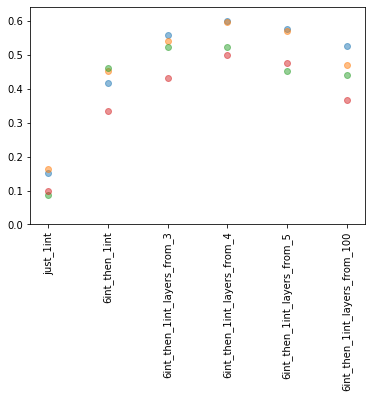

SearchScreeningEvent


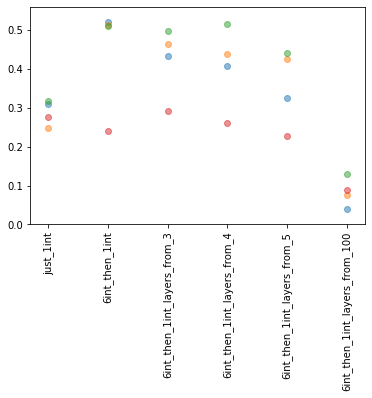

In [12]:
from IPython.utils import io

for cur_intent in intents:
    print(cur_intent)
    labels = ['just_1int', '6int_then_1int', '6int_then_1int_layers_from_3',
              '6int_then_1int_layers_from_4', '6int_then_1int_layers_from_5', '6int_then_1int_layers_from_100']
    for run in range(4):
        xs = []
        ys = []
        for x, l in enumerate(labels):
            path = paths_on10samples[cur_intent][l][run]
            xs.append(x)
            with io.capture_output(stdout=False):
                ys.append(load_scalars(path)[cur_intent][1][-1])
        plt.scatter(xs, ys, alpha=0.5)
    plt.xticks(range(len(labels)), labels, rotation=90)
    plt.ylim(ymin=0)
    plt.show()

## Fine-tuning on different number of sentences

Now let's look at how the whole frame accuracy grows with the number of available training sentences. We use the `6_int_then_1int_layers_from_4` training mode. Interestingly 500 sentences seem to be better than 1000, I'm not sure why (may be connected to the mechanism of calculating the number of steps, so it's early do draw any conclusions).

In [13]:
paths_onNsamples = {}
for excluded_intent in intents:
    samp = {}
    for samples in [10, 50, 100, 200, 500, 1000]:
        only_this_intent = {intent: 0 for intent in intents}
        only_this_intent[excluded_intent] = (samples, 1500//samples)

        runs = []

        for shift in [0, 400, 800, 1200]:
            runs.append(
                run_bert(**defaults,
                         output_dir=outdir("BERT_NLU_6INT_THEN_1INT"),
                         bert_model=paths_on6[excluded_intent] + "/checkpoint_final",
                         num_train_epochs=8,
                         limit_data=only_this_intent,
                         shift_limited_data=shift,
                         train_layers_from=4))
        
        samp[samples] = runs
    
    paths_onNsamples[excluded_intent] = samp

I0729 11:25:46.282536 140613220276032 run_bert_nlu_pytorch.py:477] device: cuda n_gpu: 1, distributed training: False, 16-bits training: True
I0729 11:25:46.284408 140613220276032 run_bert_nlu_pytorch.py:514] Output dir /workspace/output/BERT_NLU_6INT_THEN_1INT_d2677a4b already exists, doing nothing
I0729 11:25:46.285252 140613220276032 run_bert_nlu_pytorch.py:477] device: cuda n_gpu: 1, distributed training: False, 16-bits training: True
I0729 11:25:46.286850 140613220276032 run_bert_nlu_pytorch.py:514] Output dir /workspace/output/BERT_NLU_6INT_THEN_1INT_67b3e8fd already exists, doing nothing
I0729 11:25:46.287644 140613220276032 run_bert_nlu_pytorch.py:477] device: cuda n_gpu: 1, distributed training: False, 16-bits training: True
I0729 11:25:46.289119 140613220276032 run_bert_nlu_pytorch.py:514] Output dir /workspace/output/BERT_NLU_6INT_THEN_1INT_bdd08ea7 already exists, doing nothing
I0729 11:25:46.289851 140613220276032 run_bert_nlu_pytorch.py:477] device: cuda n_gpu: 1, distrib

I0729 11:25:46.342076 140613220276032 run_bert_nlu_pytorch.py:514] Output dir /workspace/output/BERT_NLU_6INT_THEN_1INT_2280684f already exists, doing nothing
I0729 11:25:46.342682 140613220276032 run_bert_nlu_pytorch.py:477] device: cuda n_gpu: 1, distributed training: False, 16-bits training: True
I0729 11:25:46.344117 140613220276032 run_bert_nlu_pytorch.py:514] Output dir /workspace/output/BERT_NLU_6INT_THEN_1INT_94a2e976 already exists, doing nothing
I0729 11:25:46.344672 140613220276032 run_bert_nlu_pytorch.py:477] device: cuda n_gpu: 1, distributed training: False, 16-bits training: True
I0729 11:25:46.346165 140613220276032 run_bert_nlu_pytorch.py:514] Output dir /workspace/output/BERT_NLU_6INT_THEN_1INT_4d04f41d already exists, doing nothing
I0729 11:25:46.346698 140613220276032 run_bert_nlu_pytorch.py:477] device: cuda n_gpu: 1, distributed training: False, 16-bits training: True
I0729 11:25:46.348337 140613220276032 run_bert_nlu_pytorch.py:514] Output dir /workspace/output/B

I0729 11:25:46.400129 140613220276032 run_bert_nlu_pytorch.py:477] device: cuda n_gpu: 1, distributed training: False, 16-bits training: True
I0729 11:25:46.401541 140613220276032 run_bert_nlu_pytorch.py:514] Output dir /workspace/output/BERT_NLU_6INT_THEN_1INT_6612df84 already exists, doing nothing
I0729 11:25:46.402169 140613220276032 run_bert_nlu_pytorch.py:477] device: cuda n_gpu: 1, distributed training: False, 16-bits training: True
I0729 11:25:46.403590 140613220276032 run_bert_nlu_pytorch.py:514] Output dir /workspace/output/BERT_NLU_6INT_THEN_1INT_453660fb already exists, doing nothing
I0729 11:25:46.404170 140613220276032 run_bert_nlu_pytorch.py:477] device: cuda n_gpu: 1, distributed training: False, 16-bits training: True
I0729 11:25:46.405644 140613220276032 run_bert_nlu_pytorch.py:514] Output dir /workspace/output/BERT_NLU_6INT_THEN_1INT_6c1c972b already exists, doing nothing
I0729 11:25:46.406219 140613220276032 run_bert_nlu_pytorch.py:477] device: cuda n_gpu: 1, distrib

I0729 11:25:46.459377 140613220276032 run_bert_nlu_pytorch.py:514] Output dir /workspace/output/BERT_NLU_6INT_THEN_1INT_471cca07 already exists, doing nothing
I0729 11:25:46.460014 140613220276032 run_bert_nlu_pytorch.py:477] device: cuda n_gpu: 1, distributed training: False, 16-bits training: True
I0729 11:25:46.461513 140613220276032 run_bert_nlu_pytorch.py:514] Output dir /workspace/output/BERT_NLU_6INT_THEN_1INT_aeaf5264 already exists, doing nothing
I0729 11:25:46.462180 140613220276032 run_bert_nlu_pytorch.py:477] device: cuda n_gpu: 1, distributed training: False, 16-bits training: True
I0729 11:25:46.463681 140613220276032 run_bert_nlu_pytorch.py:514] Output dir /workspace/output/BERT_NLU_6INT_THEN_1INT_6765b230 already exists, doing nothing
I0729 11:25:46.464294 140613220276032 run_bert_nlu_pytorch.py:477] device: cuda n_gpu: 1, distributed training: False, 16-bits training: True
I0729 11:25:46.465874 140613220276032 run_bert_nlu_pytorch.py:514] Output dir /workspace/output/B

I0729 11:25:46.518191 140613220276032 run_bert_nlu_pytorch.py:477] device: cuda n_gpu: 1, distributed training: False, 16-bits training: True
I0729 11:25:46.519737 140613220276032 run_bert_nlu_pytorch.py:514] Output dir /workspace/output/BERT_NLU_6INT_THEN_1INT_4b5af42c already exists, doing nothing
I0729 11:25:46.520360 140613220276032 run_bert_nlu_pytorch.py:477] device: cuda n_gpu: 1, distributed training: False, 16-bits training: True
I0729 11:25:46.521840 140613220276032 run_bert_nlu_pytorch.py:514] Output dir /workspace/output/BERT_NLU_6INT_THEN_1INT_b3cba624 already exists, doing nothing
I0729 11:25:46.522507 140613220276032 run_bert_nlu_pytorch.py:477] device: cuda n_gpu: 1, distributed training: False, 16-bits training: True
I0729 11:25:46.524044 140613220276032 run_bert_nlu_pytorch.py:514] Output dir /workspace/output/BERT_NLU_6INT_THEN_1INT_96e31712 already exists, doing nothing
I0729 11:25:46.524657 140613220276032 run_bert_nlu_pytorch.py:477] device: cuda n_gpu: 1, distrib

I0729 11:25:46.578400 140613220276032 run_bert_nlu_pytorch.py:514] Output dir /workspace/output/BERT_NLU_6INT_THEN_1INT_6b0c4f59 already exists, doing nothing
I0729 11:25:46.579112 140613220276032 run_bert_nlu_pytorch.py:477] device: cuda n_gpu: 1, distributed training: False, 16-bits training: True
I0729 11:25:46.580572 140613220276032 run_bert_nlu_pytorch.py:514] Output dir /workspace/output/BERT_NLU_6INT_THEN_1INT_b630a65a already exists, doing nothing
I0729 11:25:46.581259 140613220276032 run_bert_nlu_pytorch.py:477] device: cuda n_gpu: 1, distributed training: False, 16-bits training: True
I0729 11:25:46.582910 140613220276032 run_bert_nlu_pytorch.py:514] Output dir /workspace/output/BERT_NLU_6INT_THEN_1INT_3ad05e27 already exists, doing nothing
I0729 11:25:46.583582 140613220276032 run_bert_nlu_pytorch.py:477] device: cuda n_gpu: 1, distributed training: False, 16-bits training: True
I0729 11:25:46.585081 140613220276032 run_bert_nlu_pytorch.py:514] Output dir /workspace/output/B

I0729 11:25:46.638720 140613220276032 run_bert_nlu_pytorch.py:477] device: cuda n_gpu: 1, distributed training: False, 16-bits training: True
I0729 11:25:46.640295 140613220276032 run_bert_nlu_pytorch.py:514] Output dir /workspace/output/BERT_NLU_6INT_THEN_1INT_a65af5be already exists, doing nothing
I0729 11:25:46.641022 140613220276032 run_bert_nlu_pytorch.py:477] device: cuda n_gpu: 1, distributed training: False, 16-bits training: True
I0729 11:25:46.642601 140613220276032 run_bert_nlu_pytorch.py:514] Output dir /workspace/output/BERT_NLU_6INT_THEN_1INT_123c871d already exists, doing nothing
I0729 11:25:46.643341 140613220276032 run_bert_nlu_pytorch.py:477] device: cuda n_gpu: 1, distributed training: False, 16-bits training: True
I0729 11:25:46.644813 140613220276032 run_bert_nlu_pytorch.py:514] Output dir /workspace/output/BERT_NLU_6INT_THEN_1INT_cac76e06 already exists, doing nothing


In [14]:
torch.cuda.empty_cache()

AddToPlaylist


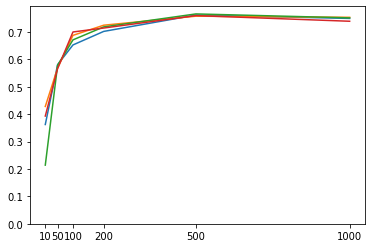

BookRestaurant


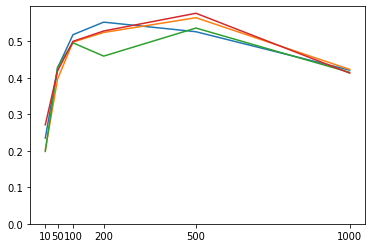

GetWeather


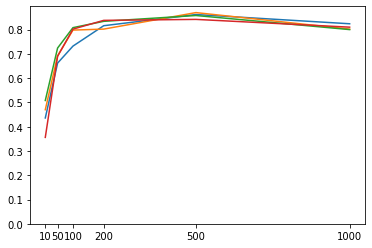

PlayMusic


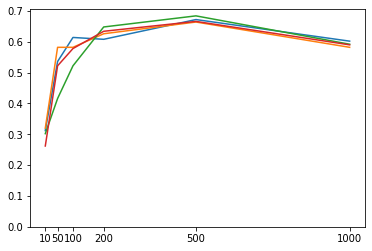

RateBook


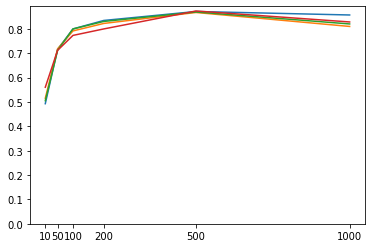

SearchCreativeWork


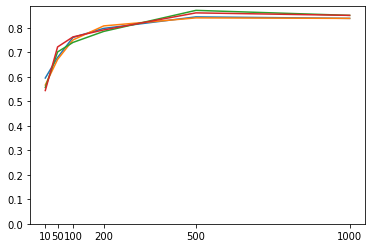

SearchScreeningEvent


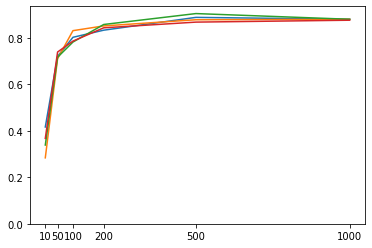

In [15]:
from IPython.utils import io

for cur_intent in intents:
    print(cur_intent)
    samples = list(paths_onNsamples[cur_intent].keys())
    with io.capture_output(stdout=False):
#         for runs in paths_onNsamples[cur_intent].values():
#             for path in runs:
#                 print(load_scalars(path)[cur_intent][1])
        scores = [[load_scalars(path)[cur_intent][1][-1] for path in runs] 
                  for runs in paths_onNsamples[cur_intent].values()]
    for run in range(4):
        plt.plot(samples, [lst[run] for lst in scores])
    plt.xticks(samples)
    plt.ylim(ymin=0)
    plt.show()